In [72]:
%pip install yfinance -q

Note: you may need to restart the kernel to use updated packages.


# Copper Futures Daily Trading Strategy: External Markers with Recursive Least Squares

**William Zhang**
(Spring 2026 Boiler Quant Onboarding)

The goal of this notebook is to build a trading strategy for copper futures (COMEX: HGH6, or HG=F on other exchanges) that uses external market data to inform its predictions. Rather than just looking at copper prices in isolation, I designed this strategy based on the idea that copper is intricately connected to broader markers/indicators of economic activity: mining companies, industrial demand, the US dollar strength, construction spending, and so on. If we can track what those related markets are doing, we might be able to predict where copper prices are headed.

The core algorithm is Recursive Least Squares (RLS), which is essentially a form of adaptive linear regression. Unlike a standard regression where you fit once on historical data and hope the relationships hold, RLS updates its coefficient estimates every single day as new data comes in. This matters because copper markets go through different phases of changes. Sometimes copper tracks the dollar closely, sometimes it trades more on supply disruptions, and RLS handles that shifting behavior naturally.

After a lot of experimentation, the strategy that actually works here is contrarian mean-reversion. Copper in the 2010-2024 period was mostly range-bound (it actually lost about 20% over 14 years), so trend-following approaches just bleed money on false breakouts. Instead, we fade extreme moves: when copper is overbought relative to recent history, we short it, and when it is oversold, we go long.

## Key Components

- **Supply indicators**: Major copper producers (FCX, SCCO, TECK). Their stock prices reflect supply-side conditions before copper futures react
- **Demand indicators**: Manufacturing and construction proxies (CAT, NUE, AA). These companies consume copper or serve end markets that do.
- **Macro conditions**: Industrial production (INDPRO) and construction spending (TLRESCONS) from the Federal Reserve database.
- **Currency effects**: US Dollar Index (DX-Y.NYB). Copper futures are predominately is priced in USD, so a strong dollar puts downward pressure on prices for non-US buyers.

## Data Sources

Actual data is queried from Yahoo Finance (price series, dollar index) and the Federal Reserve Economic Data API (macro indicators). Synthetic test data generation exists in the code but is disabled by default to make sure we only backtest on actual market data.

## Backtested Performance (2010-2024, Real Data)

The strategy trades copper futures daily with 1 basis point transaction costs.

| Metric | RLS Strategy | Buy & Hold | 60d Momentum |
|---|---|---|---|
| Total Return | +15.9% | -20.0% | -21.0% |
| CAGR | +1.06% | -1.58% | -1.67% |
| Sharpe Ratio | 0.23 | 0.04 | 0.04 |
| Max Drawdown | -12.5% | -63.0% | -51.0% |
| Annualized Vol | 5.2% | 22.6% | 22.3% |

The return itself is low, at about 1% per year. However, over this same period, simply holding copper lost 20%. The 60-day momentum strategy (a common trend-following baseline) did even worse. What the RLS strategy does well is risk control. That is, it has roughly 4x lower volatility and 5x lower drawdowns than buy-and-hold.

### How it works in practice

The strategy is long about 33% of trading days, short about 29%, and flat (no position) the remaining 38%. That large neutral fraction comes from the signal threshold filter, when the model's prediction is too small to be meaningful (under 0.2%), we just stay out. This avoids racking up transaction costs on weak signals.

Position sizes are set by a mean-variance optimization rule: predicted return divided by (risk aversion * recent volatility). Larger predictions relative to volatility lead to bigger positions, capped at 2.5x leverage in either direction.

In [73]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Wider display so DataFrames aren't truncated
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

# ------- Configuration -------
# Backtest window: 14 years of daily data
START = "2010-01-01"
END   = "2024-01-01"

# Set both of these to True/False to control data source
# With PREFER_REAL_DATA=True and ALLOW_SYNTHETIC_FALLBACK=False,
# the notebook will fail loudly if any download breaks, which is what we want
PREFER_REAL_DATA = True
ALLOW_SYNTHETIC_FALLBACK = False

# Yahoo Finance tickers
COPPER_TICKER = "HG=F"       # CME copper futures (continuous front month)
DOLLAR_TICKER = "DX-Y.NYB"   # ICE US Dollar Index

# Related equities -- chosen because their businesses are directly tied to copper
EQUITY_TICKERS = {
    "FCX":  "FCX",   # Freeport-McMoRan: world's largest publicly traded copper producer
    "SCCO": "SCCO",  # Southern Copper: another major producer, mostly Peru/Mexico
    "TECK": "TECK",  # Teck Resources: diversified miner with significant copper exposure
    "CAT":  "CAT",   # Caterpillar: sells heavy equipment to construction and mining
    "NUE":  "NUE",   # Nucor: steel producer, proxy for overall industrial activity
    "AA":   "AA",    # Alcoa: aluminum producer, tracks base metal demand broadly
}

# Federal Reserve Economic Data (FRED) series
# These are monthly and get forward-filled to daily
FRED_SERIES = {
    "INDPRO": "INDPRO",           # Industrial Production Index (monthly)
    "CONSTRUCTION": "TLRESCONS",  # Total Residential Construction Spending (monthly)
}

## Download Helpers

Utility functions for HTTP requests and CSV parsing. The retry logic is important because Yahoo Finance and FRED both rate-limit aggressively.

In [74]:
# HTTP session with automatic retries
# Yahoo Finance and FRED both rate-limit, so if a request fails with a 429
# (too many requests) or 5xx (server error), we wait and try again up to 5 times
def make_http_session(
    total_retries: int = 5,
    backoff_factor: float = 0.5,
    status_forcelist: Tuple[int, ...] = (429, 500, 502, 503, 504),
) -> requests.Session:
    session = requests.Session()
    retry = Retry(
        total=total_retries,
        read=total_retries,
        connect=total_retries,
        backoff_factor=backoff_factor,       # wait 0.5s, 1s, 2s, 4s between retries
        status_forcelist=status_forcelist,
        allowed_methods=("GET", "HEAD"),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    # Pretend to be a normal browser so we don't get blocked
    session.headers.update({
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    })
    return session

_HTTP = make_http_session()

def download_text(url: str, timeout: int = 30) -> str:
    """Download a URL and return the response body as text."""
    r = _HTTP.get(url, timeout=timeout)
    if not r.ok:
        raise RuntimeError(f"HTTP {r.status_code} for {url}")
    return r.text

def download_csv_to_df(url: str, timeout: int = 30, **read_csv_kwargs) -> pd.DataFrame:
    """Download a CSV file from the web and parse it into a DataFrame."""
    text = download_text(url, timeout=timeout)
    from io import StringIO
    return pd.read_csv(StringIO(text), **read_csv_kwargs)

def ensure_datetime_index(df: pd.DataFrame, date_col: str = "Date") -> pd.DataFrame:
    """Convert a column to datetime and set it as the index.
    Drops rows where the date can't be parsed, removes duplicate dates."""
    df = df.copy()
    if date_col not in df.columns:
        raise ValueError(f"Expected date column '{date_col}'. Found: {df.columns.tolist()}")
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()
    df = df[~df.index.duplicated(keep="last")]
    return df

def clip_date_range(s: pd.Series, start: str, end: str) -> pd.Series:
    """Trim a series to only include dates within the backtest window."""
    return s.loc[pd.to_datetime(start):pd.to_datetime(end)]

## Data Downloaders

Two main data sources: Yahoo Finance for daily price data (copper futures, dollar index, equities) and FRED for monthly macro indicators. The FRED data comes as a CSV that we parse directly -- no API key needed.

In [75]:
def fetch_yahoo_close(ticker: str, start: str, end: str) -> pd.Series:
    """Pull daily close prices from Yahoo Finance for a given ticker.
    
    Returns a Series indexed by date. Raises an error if the download
    fails or returns an empty dataset -- we don't want to silently
    proceed with missing data.
    """
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df.empty:
            raise ValueError(f"No data returned for {ticker}")
        
        # yfinance sometimes returns multi-level columns, flatten them
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        
        # Try to find a close price column
        close_col = None
        for c in ["Close", "close", "Adj Close"]:
            if c in df.columns:
                close_col = c
                break
        
        if close_col is None:
            raise ValueError(f"No Close column found for {ticker}")
        
        s = pd.to_numeric(df[close_col], errors="coerce").dropna()
        s.index = pd.to_datetime(s.index)
        s = s.rename(ticker)
        
        if s.empty:
            raise ValueError(f"Empty price series for {ticker}")
        
        return s.sort_index()
    except Exception as e:
        raise RuntimeError(f"Failed to download {ticker}: {str(e)}")

def fetch_fred_series(series_id: str) -> pd.Series:
    """Pull a data series from FRED (Federal Reserve Economic Data).
    
    FRED provides a free CSV download endpoint that doesn't require
    an API key. The data is monthly for the series we use (INDPRO and
    TLRESCONS), so it gets forward-filled to daily later.
    """
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = download_csv_to_df(url)
    if df.shape[1] < 2:
        raise ValueError(f"Unexpected FRED CSV shape for {series_id}: {df.shape}")
    df.columns = ["Date", series_id]
    df = ensure_datetime_index(df, "Date")
    s = pd.to_numeric(df[series_id], errors="coerce").rename(series_id)
    s = s.dropna()
    if s.empty:
        raise ValueError(f"Empty FRED series: {series_id}")
    return s.sort_index()

## Build Daily Dataset

This is where all the data gets pulled together into a single DataFrame. Equity prices and the dollar index are already daily. FRED data is monthly, so we forward-fill it to daily frequency (each day inherits the most recent monthly reading). The synthetic data generator exists as a fallback but is disabled.

In [76]:
def make_synthetic_daily_dataset(start: str, end: str, freq: str = "B") -> pd.DataFrame:
    """Generate fake copper market data for testing purposes.
    
    This creates a synthetic dataset that mimics the statistical properties
    of real copper markets (time-varying betas, correlated mining stocks, etc.)
    but is NOT used for the actual backtest. It exists only as a fallback
    if the Yahoo Finance or FRED downloads fail, and is disabled by default.
    """
    idx = pd.date_range(start=start, end=end, freq=freq)
    n = len(idx)
    t = np.arange(n)

    # Simulate underlying economic drivers with cyclical and random components
    industrial = 0.02*np.sin(2*np.pi*t/252) + 0.10*np.random.randn(n)
    supply = 0.02*np.cos(2*np.pi*t/126) + 0.10*np.random.randn(n)
    dollar = 0.01*np.sin(2*np.pi*t/504) + 0.08*np.random.randn(n)
    construction = 0.03*np.sin(2*np.pi*t/(252*2)) + 0.10*np.random.randn(n)

    # Time-varying factor loadings (this is what makes static regression fail)
    beta_i = 0.12 + 0.08*np.sin(2*np.pi*t/(252*3))
    beta_s = 0.10 + 0.06*np.cos(2*np.pi*t/(252*2))
    beta_d = -0.08 + 0.04*np.sin(2*np.pi*t/(252*5))  # negative: strong dollar hurts copper
    beta_c = 0.09 + 0.05*np.cos(2*np.pi*t/(252*4))

    eps = 0.25*np.random.randn(n)
    r_copper = beta_i*industrial + beta_s*supply + beta_d*dollar + beta_c*construction + eps
    copper_price = 3.0*np.exp(np.cumsum(r_copper/100))

    # Mining company prices (correlated with supply factor)
    FCX = 30*np.exp(np.cumsum((0.18*supply + 0.10*np.random.randn(n))/100))
    SCCO = 50*np.exp(np.cumsum((0.16*supply + 0.10*np.random.randn(n))/100))
    TECK = 20*np.exp(np.cumsum((0.14*supply + 0.10*np.random.randn(n))/100))
    # Industrial demand proxies
    CAT = 150*np.exp(np.cumsum((0.14*industrial + 0.10*np.random.randn(n))/100))
    NUE = 80*np.exp(np.cumsum((0.12*industrial + 0.12*np.random.randn(n))/100))
    AA = 35*np.exp(np.cumsum((0.13*industrial + 0.12*np.random.randn(n))/100))

    indpro = 100 + np.cumsum(0.05 + 0.2*industrial + 0.1*np.random.randn(n))
    construction_sp = 1000 + np.cumsum(0.8 + 0.5*construction + 0.3*np.random.randn(n))
    dollar_idx = 95 + np.cumsum(0.02*dollar + 0.15*np.random.randn(n))

    return pd.DataFrame(
        {
            "COPPER": copper_price,
            "FCX": FCX, "SCCO": SCCO, "TECK": TECK,
            "CAT": CAT, "NUE": NUE, "AA": AA,
            "INDPRO": indpro,
            "CONSTRUCTION": construction_sp,
            "DOLLAR": dollar_idx,
        },
        index=idx,
    )

def build_daily_dataset(start: str, end: str) -> Tuple[pd.DataFrame, str]:
    """Download and assemble all data sources into one DataFrame.
    
    Returns a tuple of (DataFrame, data_mode) where data_mode is
    either 'real' or 'synthetic'. With our current config, we only
    accept real data and will raise an error if downloads fail.
    """
    if not PREFER_REAL_DATA:
        df = make_synthetic_daily_dataset(start, end)
        return df, "synthetic"

    try:
        # Step 1: Get the target -- copper futures close prices
        print("Downloading daily copper futures from Yahoo Finance...")
        copper_daily = fetch_yahoo_close(COPPER_TICKER, start, end).rename("COPPER")
        print(f"Copper: {len(copper_daily)} days")

        # Step 2: Get the US Dollar Index (copper's biggest macro driver)
        print("\nDownloading US Dollar Index...")
        dollar_daily = fetch_yahoo_close(DOLLAR_TICKER, start, end).rename("DOLLAR")
        print(f"Dollar Index: {len(dollar_daily)} days")

        # Step 3: Download all the related equity prices
        print("\nDownloading daily equities from Yahoo Finance...")
        eq_daily = {}
        for k, ticker in EQUITY_TICKERS.items():
            eq_daily[k] = fetch_yahoo_close(ticker, start, end).rename(k)
            print(f"{k}: {len(eq_daily[k])} days")

        # Merge everything on date, forward-fill any gaps (holidays differ
        # between futures and equity markets), drop days with no copper data
        daily = pd.concat([copper_daily, dollar_daily] + list(eq_daily.values()), axis=1)
        daily = daily.loc[pd.to_datetime(start):pd.to_datetime(end)]
        daily = daily.fillna(method='ffill').dropna(subset=["COPPER"])
        print(f"\n{len(daily)} daily observations")

        # Step 4: Get the FRED macro data (monthly, forward-filled to daily)
        # Each daily row inherits the most recent monthly value
        print("\nDownloading FRED macro data (forward-filled to daily)...")
        fred_series = {}
        for name, sid in FRED_SERIES.items():
            s = fetch_fred_series(sid).rename(name)
            s = clip_date_range(s, start, end)
            fred_series[name] = s.reindex(daily.index, method='ffill')
            print(f"{name}: forward-filled to daily")

        df = daily.copy()
        for name, s in fred_series.items():
            df[name] = s

        df = df.sort_index().ffill()
        print(f"\nSuccessfully downloaded real daily market data")
        print(f"Final dataset: {len(df)} trading days from {df.index[0].date()} to {df.index[-1].date()}")
        print(f"Ready for daily trading with long/short positions\n")
        return df, "real"
    except Exception as e:
        if not ALLOW_SYNTHETIC_FALLBACK:
            print(f"\nDownload failed: {e}")
            raise
        print(f"Warning: Download failed, using synthetic data: {e}")
        return make_synthetic_daily_dataset(start, end), "synthetic"

data, mode = build_daily_dataset(START, END)
print(f"Data mode: {mode}")
print(f"Trading frequency: DAILY ({len(data)} observations)")
data.head()

Copper: 3520 days

Dollar Index: 3521 days

FCX: 3522 days
SCCO: 3522 days
TECK: 3522 days
CAT: 3522 days
NUE: 3522 days
AA: 3522 days

3524 daily observations

INDPRO: forward-filled to daily
CONSTRUCTION: forward-filled to daily

Successfully downloaded real daily market data
Final dataset: 3524 trading days from 2010-01-04 to 2023-12-29
Ready for daily trading with long/short positions

Data mode: real
Trading frequency: DAILY (3524 observations)


,COPPER,DOLLAR,FCX,SCCO,TECK,CAT,NUE,AA,INDPRO,CONSTRUCTION
Date,,,,,,,,,,
2010-01-04,3.3880,77.529999,29.927420,17.264975,28.294308,39.198860,31.084188,35.359657,89.3426,263680
2010-01-05,3.3960,77.620003,30.106714,17.435465,29.087812,39.667530,31.298840,34.255341,89.3426,263680
2010-01-06,3.4775,77.489998,31.307953,18.002108,29.616819,39.788029,32.241970,36.039261,89.3426,263680
2010-01-07,3.4115,77.910004,30.709139,17.831608,29.624386,39.948715,32.020805,35.274715,89.3426,263680
2010-01-08,3.3880,77.470001,31.591253,18.182621,30.637049,40.397259,32.476128,36.145435,89.3426,263680


## Data Validation

More checks to make sure the downloaded data is clean with no duplicate dates, prices are positive, the index looks like daily business-day frequency (gaps of 1-3 days, accounting for weekends). If any of these fail, something went wrong with the download.

In [77]:
# Columns we absolutely need vs columns that are nice to have
REQUIRED = ["COPPER"]
OPTIONAL = ["FCX", "SCCO", "TECK", "CAT", "NUE", "AA", "INDPRO", "CONSTRUCTION", "DOLLAR"]

def validate_dataset(df: pd.DataFrame):
    """Run sanity checks on the combined dataset before we start feature engineering.
    
    These catch common data issues that would silently produce garbage results:
    - Non-datetime index (wrong data type)
    - Unsorted dates (would mess up rolling calculations)
    - Duplicate dates (would double-count observations)
    - Missing copper prices (the target variable)
    - Non-numeric values hiding in supposedly numeric columns
    - Wrong frequency (e.g., if we accidentally got weekly data)
    """
    assert isinstance(df.index, pd.DatetimeIndex), "Index must be DatetimeIndex"
    assert df.index.is_monotonic_increasing, "Dates must be sorted"
    assert not df.index.duplicated().any(), "No duplicate dates allowed"

    for c in REQUIRED:
        assert c in df.columns, f"Missing required column: {c}"

    # Force everything to numeric -- this catches stray strings like "N/A"
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Copper prices should be positive (it's a physical commodity)
    assert (df["COPPER"] > 0).mean() > 0.99, "COPPER has too many non-positive values."

    # Check that the data is roughly daily (gaps of 1-3 days for weekends)
    # If more than 10% of gaps are larger, something is wrong
    deltas = df.index.to_series().diff().dropna()
    frac_daily = ((deltas.dt.days >= 1) & (deltas.dt.days <= 3)).mean()
    assert frac_daily > 0.90, f"Index doesn't look daily (daily fraction={frac_daily:.2f})."

    return df

data = validate_dataset(data)
print(f"Dataset validated: {len(data)} trading days, {len(data.columns)} columns")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Columns present: {list(data.columns)}")
data.describe().T.head(12)

Dataset validated: 3524 trading days, 10 columns
Date range: 2010-01-04 to 2023-12-29
Columns present: ['COPPER', 'DOLLAR', 'FCX', 'SCCO', 'TECK', 'CAT', 'NUE', 'AA', 'INDPRO', 'CONSTRUCTION']


,count,mean,std,min,25%,50%,75%,max
COPPER,3524.0,3.253623,0.664973,1.939500,2.719250,3.198000,3.733500,4.929000
DOLLAR,3524.0,91.345068,9.122641,72.930000,81.514997,93.800003,97.642500,114.110001
FCX,3524.0,23.477011,10.935414,3.383989,12.344165,25.435289,32.132719,48.956516
SCCO,3524.0,29.547328,15.051765,13.294403,18.564113,23.391998,35.500366,79.006149
TECK,3524.0,22.782487,9.885820,2.360356,16.442887,21.509695,28.764400,49.739277
CAT,3524.0,108.830379,59.252729,34.228844,63.148879,79.707394,131.707432,288.374298
NUE,3524.0,55.988935,37.377009,21.402433,32.380095,40.821627,53.517735,172.318634
AA,3524.0,29.807330,12.330038,5.234374,20.822872,27.775274,36.112889,91.097961
INDPRO,3524.0,99.092492,3.544741,84.561900,97.706050,100.082000,101.333500,104.100400
CONSTRUCTION,3524.0,526050.140182,218631.339087,247981.000000,334273.000000,518928.000000,624159.000000,988269.000000


## Feature Engineering

We are trying to catch when copper is distorted away from its fair value and likely to revert. The 23 features fall into a few categories:

- **Mean reversion signals**: Z-scores of returns at different lookbacks, distance from moving averages, Bollinger Band position. These directly measure how far price has deviated from recent norms.
- **RSI (Relative Strength Index)**: Classic overbought/oversold indicator, but we flip it into a contrarian signal so that high RSI means "expect a drop."
- **Momentum divergence**: When 1-week and 1-month momentum point in opposite directions, the short-term direction is often wrong.
- **Volatility and distribution**: Higher volatility generally means bigger mean-reversion opportunities. Skewness warns about asymmetric risk.
- **External signals**: Z-scored returns from mining stocks (supply side) and industrial companies (demand side), plus the dollar and FRED macro data.
- **Seasonality**: Sine/cosine encoding of month. There is some evidence that copper has seasonal patterns.

All features get any invalid data points replaced with zero (neutral).

In [78]:
def logret(s: pd.Series) -> pd.Series:
    """Calculate log returns for a price series.
    
    Log returns are preferred over simple returns because:
    1. They are symmetric: log(P2/P1) = -log(P1/P2)
    2. They are additive over time: log(P3/P1) = log(P2/P1) + log(P3/P2)
    3. They approximate simple returns for small changes
    """
    return np.log(s).diff()

def zscore(x: pd.Series, window: int) -> pd.Series:
    """Standardize a series to have zero mean and unit variance over a rolling window.
    
    Z-scores identify extreme values: z > 2 or z < -2 are unusual (95% of data lies within ±2 std)
    This normalization makes indicators comparable across different volatility regimes.
    """
    mu = x.rolling(window).mean()
    sd = x.rolling(window).std(ddof=0)
    return (x - mu) / sd

def make_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Engineer features for mean-reversion prediction.
    
    Returns:
        X: Feature matrix with 23 columns
        y_next: Target variable (next-day log return)
    
    Feature categories:
    1. Mean reversion signals (z-scores, distance from MA, Bollinger Bands)
    2. Momentum indicators (RSI, momentum divergence)
    3. External market signals (mining stocks, industrial demand, dollar)
    4. Technical indicators (volatility, skewness, trend)
    """
    df = df.copy()

    # Target variable: next day's log return
    r_copper = logret(df["COPPER"]).rename("r_copper")
    y_next = r_copper.shift(-1).rename("y_next")

    # Calculate log returns for all equity series
    eq_cols = [c for c in ["FCX","SCCO","TECK","CAT","NUE","AA"] if c in df.columns]
    for c in eq_cols:
        df[f"r_{c}"] = logret(df[c])

    # Dollar index: Copper is priced in USD, so dollar strength mechanically affects demand
    # Strong dollar = more expensive for non-US buyers = lower demand
    if "DOLLAR" in df.columns:
        df["r_dollar"] = logret(df["DOLLAR"])
        # Z-score identifies when dollar is overbought/oversold relative to recent range
        df["dollar_z"] = zscore(df["DOLLAR"], window=60)
    
    # Macro indicators: Forward-filled from monthly FRED data
    # These capture fundamental demand trends that evolve slowly
    if "INDPRO" in df.columns:
        df["indpro_chg"] = df["INDPRO"].pct_change(20)
    if "CONSTRUCTION" in df.columns:
        df["construction_chg"] = df["CONSTRUCTION"].pct_change(20)

    # ===== MEAN REVERSION FEATURES =====
    # Core hypothesis: extreme price moves tend to reverse
    
    # Short-term and medium-term z-scores of returns
    # z > 2: Unusually large positive return, likely to reverse downward
    # z < -2: Unusually large negative return, likely to bounce upward
    df["z_score_20"] = zscore(r_copper, window=20)
    df["z_score_60"] = zscore(r_copper, window=60)
    
    # Distance from 60-day moving average
    # Positive = above MA (potentially overbought), Negative = below MA (potentially oversold)
    df["price_pct_from_ma60"] = (df["COPPER"] / df["COPPER"].rolling(60).mean() - 1.0)
    
    # ===== RSI: PRIMARY CONTRARIAN INDICATOR =====
    # RSI measures momentum on 0-100 scale
    # Use exponential moving average for smoother adaptation
    gains = r_copper.clip(lower=0)  # Only positive returns
    losses = -r_copper.clip(upper=0)  # Only negative returns (made positive)
    avg_gain = gains.ewm(span=14, adjust=False).mean()
    avg_loss = losses.ewm(span=14, adjust=False).mean()
    rs = avg_gain / (avg_loss + 1e-8)  # Relative strength
    df["rsi"] = 100 - (100 / (1 + rs))
    
    # Transform RSI into contrarian signal: 
    # RSI=100 (extreme overbought) → rsi_contrarian=-1 (short signal)
    # RSI=0 (extreme oversold) → rsi_contrarian=+1 (long signal)
    # RSI=50 (neutral) → rsi_contrarian=0 (no signal)
    df["rsi_contrarian"] = -(df["rsi"] - 50) / 50
    
    # ===== MOMENTUM DIVERGENCE =====
    # When short-term and medium-term momentum disagree, reversals are likely
    df["mom_5"] = r_copper.rolling(5).sum()   # 1-week cumulative return
    df["mom_20"] = r_copper.rolling(20).sum() # 1-month cumulative return
    # Divergence signal: +1 if short-term down but medium-term up (reversal up?)
    #                    -1 if short-term up but medium-term down (reversal down?)
    df["mom_reversal"] = np.sign(df["mom_5"]) * -np.sign(df["mom_20"])
    
    # ===== VOLATILITY MEASURES =====
    # High volatility periods offer better mean-reversion opportunities
    # Vol ratio > 1: Recent volatility exceeds long-term average (unstable market)
    df["vol_20"] = r_copper.rolling(20).std(ddof=0)
    df["vol_60"] = r_copper.rolling(60).std(ddof=0)
    df["vol_ratio"] = df["vol_20"] / (df["vol_60"] + 1e-8)
    
    # ===== EXTERNAL MARKET SIGNALS =====
    # Mining stocks as supply indicators
    # If FCX (large copper producer) is weak while copper is strong, supply concerns are easing
    if "FCX" in eq_cols:
        df["mining_signal"] = zscore(df["r_FCX"], window=60)
    
    # Industrial stocks as demand indicators  
    # If CAT (construction equipment) is strong, copper demand should follow
    if "CAT" in eq_cols:
        df["demand_signal"] = zscore(df["r_CAT"], window=60)
    
    # ===== DISTRIBUTION MEASURES =====
    # Skewness detects asymmetry in return distribution
    # Negative skew: More frequent large losses than large gains (crash risk)
    df["skew_20"] = r_copper.rolling(20).skew()
    
    # ===== BOLLINGER BAND POSITION =====
    # Measures where price sits within ±2 std bands
    # bb_position = +1: At upper band (overbought, likely to fall)
    # bb_position = -1: At lower band (oversold, likely to rise)
    bb_mid = df["COPPER"].rolling(20).mean()
    bb_std = df["COPPER"].rolling(20).std(ddof=0)
    df["bb_position"] = (df["COPPER"] - bb_mid) / (2 * bb_std + 1e-8)
    
    # ===== TREND REGIME =====
    # Identifies whether we're in uptrend or downtrend
    # Positive: Short MA > Long MA (uptrend)
    # Negative: Short MA < Long MA (downtrend)
    ma_20 = df["COPPER"].rolling(20).mean()
    ma_60 = df["COPPER"].rolling(60).mean()
    df["trend"] = (ma_20 / ma_60 - 1.0)
    
    # ===== EXTREME MOVE DETECTION =====
    # Normalizes daily returns by recent volatility
    # Values > 3 or < -3 are very unusual and often reverse
    df["extreme_move"] = (r_copper / (df["vol_20"] + 1e-8)).clip(-5, 5)
    
    # ===== SEASONAL EFFECTS =====
    # Sine/cosine encoding of month preserves cyclical nature
    # Some evidence of seasonal patterns in copper (construction season, Chinese New Year)
    m = df.index.month
    df["month_sin"] = np.sin(2*np.pi*m/12)
    df["month_cos"] = np.cos(2*np.pi*m/12)

    # Assemble final feature set (23 total features)
    feature_cols = [
        "z_score_20", "z_score_60", "price_pct_from_ma60",
        "rsi", "rsi_contrarian",
        "mom_5", "mom_20", "mom_reversal",
        "vol_20", "vol_60", "vol_ratio",
        "skew_20", "bb_position", "trend", "extreme_move",
        "month_sin", "month_cos"
    ]
    
    # Add optional features if available
    if "dollar_z" in df.columns:
        feature_cols.append("dollar_z")
    if "r_dollar" in df.columns:
        df["z_r_dollar"] = zscore(df["r_dollar"], window=60)
        feature_cols.append("z_r_dollar")
    
    if "indpro_chg" in df.columns:
        feature_cols.append("indpro_chg")
    if "construction_chg" in df.columns:
        feature_cols.append("construction_chg")
    
    if "mining_signal" in df.columns:
        feature_cols.append("mining_signal")
    if "demand_signal" in df.columns:
        feature_cols.append("demand_signal")

    # Replace infinities and missing values with zero
    X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X, y_next

X, y = make_features(data)
print(f"X shape: {X.shape} (daily frequency)")
print(f"Features ({len(X.columns)}): {list(X.columns[:15])}")
print(f"Contrarian mean-reversion features selected")
X.head()

X shape: (3524, 23) (daily frequency)
Features (23): ['z_score_20', 'z_score_60', 'price_pct_from_ma60', 'rsi', 'rsi_contrarian', 'mom_5', 'mom_20', 'mom_reversal', 'vol_20', 'vol_60', 'vol_ratio', 'skew_20', 'bb_position', 'trend', 'extreme_move']
Contrarian mean-reversion features selected


,z_score_20,z_score_60,price_pct_from_ma60,rsi,rsi_contrarian,mom_5,mom_20,mom_reversal,vol_20,vol_60,vol_ratio,skew_20,bb_position,trend,extreme_move,month_sin,month_cos,dollar_z,z_r_dollar,indpro_chg,construction_chg,mining_signal,demand_signal
Date,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.0,0.0,0.0,99.999576,-0.999992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.0,0.0,0.0,99.999808,-0.999996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-07,0.0,0.0,0.0,63.846632,-0.276933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-08,0.0,0.0,0.0,55.495516,-0.109910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.866025,0.0,0.0,0.0,0.0,0.0,0.0


## RLS Model

Recursive Least Squares is the main part of this strategy. We maintain a set of regression coefficients (one per feature) that predict tomorrow's copper return. Every day, after we observe the actual return, we update those coefficients using the RLS update rule.

The forgetting factor lambda (set to 0.99) controls how much weight we give to old data. At 0.99, the effective memory is about 100 trading days, so the model remembers roughly 5 months of history and gradually forgets anything older. This allows it to adapt when market relationships shift (for example, the copper-dollar relationship can strengthen or weaken depending on global macro conditions).

The model uses a 180-day burn-in period where it trains but does not generate trading signals. This ensures the coefficients are reasonably stable before we start risking capital. After burn-in, we predict and adjust simultaneously.

In [79]:
@dataclass
class RLS:
    """Recursive Least Squares adaptive filter.
    
    RLS maintains:
    - beta: coefficient vector (n_features,)
    - P: covariance matrix (n_features, n_features) representing estimate uncertainty
    
    At each time step, RLS:
    1. Makes a prediction using current coefficients
    2. Observes the actual outcome
    3. Updates coefficients based on prediction error
    4. Updates covariance to reflect new information
    
    The key advantage over batch regression is computational efficiency (O(n^2) per update
    vs O(n^3) for full retraining) and adaptivity to regime changes.
    """
    n_features: int
    lam: float = 0.99  # Forgetting factor: λ=0.99 gives ~100-day effective memory
    delta: float = 1e4  # Initial covariance scaling: large value = high initial uncertainty

    def __post_init__(self):
        # Initialize coefficients to zero (no prior belief about relationships)
        self.beta = np.zeros(self.n_features, dtype=float)
        
        # Initialize covariance matrix: diagonal matrix scaled by delta
        # Large delta = high initial uncertainty, allowing rapid early learning
        self.P = self.delta * np.eye(self.n_features, dtype=float)

    def predict(self, x: np.ndarray) -> float:
        """Generate prediction: ŷ = x' * beta
        
        This is a simple linear model, but coefficients adapt over time.
        """
        return float(x @ self.beta)

    def update(self, x: np.ndarray, y: float):
        """Update coefficients based on new observation (x, y).
        
        This implements the RLS update equations:
        1. Compute Kalman gain K (determines how much to adjust coefficients)
        2. Update beta using prediction error weighted by K
        3. Update covariance matrix P (uncertainty decreases with more data)
        
        The forgetting factor λ in the denominator and P update causes older
        observations to have exponentially less influence over time.
        """
        x = x.reshape(-1, 1)  # Ensure x is column vector
        
        # Kalman gain: how much to trust this new observation
        # K is large when P (uncertainty) is large or when x aligns with high-uncertainty directions
        Px = self.P @ x
        denom = self.lam + float(x.T @ Px)  # Normalization with forgetting factor
        K = Px / denom
        
        # Prediction error: how wrong was our forecast?
        err = y - float(x.T @ self.beta.reshape(-1, 1))
        
        # Update rule: move coefficients in direction that reduces error
        # Size of adjustment is proportional to K (gain) and error
        self.beta = self.beta + (K.flatten() * err)
        
        # Update covariance: uncertainty decreases after observing data
        # Division by λ implements exponential forgetting of old information
        self.P = (self.P - K @ x.T @ self.P) / self.lam

def walkforward_rls_predictions(X: pd.DataFrame, y_next: pd.Series, lam: float = 0.99, burn_in: int = 180) -> pd.Series:
    """Generate walk-forward predictions using RLS.
    
    Walk-forward means:
    - At time t, we only use data up to time t-1 for prediction
    - No look-ahead bias: strategy could have been implemented in real-time
    
    Burn-in period:
    - First 180 days are used to initialize coefficients without trading
    - This allows RLS to learn initial relationships before risking capital
    - After burn-in, we generate predictions AND continue learning simultaneously
    
    Args:
        X: Feature matrix (n_days, n_features)
        y_next: Target returns (n_days,)
        lam: Forgetting factor (0.99 = 100-day memory)
        burn_in: Number of days before making predictions
        
    Returns:
        Series of predicted next-day returns (first 180 are NaN)
    """
    Xv = X.values.astype(float)
    yv = y_next.values.astype(float)

    # Initialize RLS with dimension matching feature count
    model = RLS(n_features=X.shape[1], lam=lam)
    preds = np.full(len(X), np.nan)  # Store predictions

    for t in range(len(X)):
        x_t = Xv[t]  # Current day's features
        
        # After burn-in, generate prediction for tomorrow using today's features
        if t >= burn_in:
            preds[t] = model.predict(x_t)
        
        # If we have tomorrow's actual return, update model (learning step)
        # This happens even during burn-in, so model trains before trading
        if np.isfinite(yv[t]):
            model.update(x_t, yv[t])

    return pd.Series(preds, index=X.index, name="pred_y_next")

print("Training RLS model with contrarian features (lambda=0.99)...")
pred = walkforward_rls_predictions(X, y, lam=0.99, burn_in=180)
print(f"Generated {pred.notna().sum()} daily predictions")
print(f"First prediction date: {pred.dropna().index[0].date()}")
print(f"Last prediction date: {pred.dropna().index[-1].date()}")
pred.dropna().head()

Training RLS model with contrarian features (lambda=0.99)...
Generated 3344 daily predictions
First prediction date: 2010-09-21
Last prediction date: 2023-12-29


Date
2010-09-21    0.004981
2010-09-22    0.017173
2010-09-23   -0.001900
2010-09-24    0.012623
2010-09-27    0.010028
Name: pred_y_next, dtype: float64

## Backtest

Position sizing follows a simple mean-variance rule: the predicted return divided by (risk aversion * estimated volatility). When the model is confident about a big move and vol is low, we take a larger position. When the signal is weak or vol is high, we scale down or stay flat.

A key detail: predictions below 0.2% in magnitude get zeroed out. This acts as a noise filter. Without it, the strategy would trade almost every day on tiny signals and rack up transaction costs. With the filter, we sit out about 38% of days.

Transaction costs are modeled at 1 basis point per unit of turnover. So if we go from position +1.0 to -0.5, that is 1.5 units of turnover costing 0.015% of portfolio value. This is conservative for copper futures, where actual trading costs are often lower, but it is better to be pessimistic in a backtest.

In [80]:
def backtest(
    copper_prices: pd.Series,
    pred_y_next: pd.Series,
    vol_window: int = 60,
    gamma: float = 1.8,
    w_max: float = 2.5,
    cost_per_turnover: float = 0.00010,
    min_prediction_threshold: float = 0.002,
) -> pd.DataFrame:
    """Simulate trading the strategy day by day and track P&L.
    
    The position each day is determined by a mean-variance optimization:
        position = predicted_return / (gamma * estimated_volatility)
    
    Think of it this way: if we predict a big move and recent vol is low,
    we take a bigger bet. If the prediction is small or vol is high, we
    bet less (or nothing at all, if the prediction is below the threshold).
    
    Parameters:
        copper_prices: daily close prices for HG=F
        pred_y_next:   model's prediction for next-day return (from RLS)
        vol_window:    lookback for estimating daily volatility (60 days)
        gamma:         risk aversion (1.8 -- moderate)
        w_max:         max leverage in either direction (2.5x)
        cost_per_turnover: transaction cost per unit of position change (1bp)
        min_prediction_threshold: ignore predictions smaller than this (0.2%)
    """
    copper_prices = copper_prices.astype(float)
    
    # Calculate actual daily log returns
    r = logret(copper_prices).rename("r")
    
    # Estimate volatility using 60-day rolling standard deviation
    # This adapts to changing market regimes (2020 had much higher vol than 2019)
    vol = r.rolling(vol_window).std(ddof=0).rename("vol")
    
    # Align predictions with return series
    pred = pred_y_next.reindex(r.index)

    # Position sizing: scale predictions by volatility
    # If pred = 0.01 (1% expected return) and vol = 0.02 (2% daily vol):
    #   raw_w = 0.01 / (1.8 * 0.02) = 0.28 (28% position)
    # Higher predictions → larger positions
    # Higher volatility → smaller positions (risk control)
    raw_w = pred / (gamma * vol)
    
    # Apply leverage cap to prevent extreme positions
    w = raw_w.clip(-w_max, w_max)
    
    # Signal threshold: don't trade when predictions are small
    # |pred| < 0.2% is likely noise, not signal
    # This reduces transaction costs from overtrading
    w[pred.abs() < min_prediction_threshold] = 0.0
    w = w.fillna(0.0).rename("w")
    
    # Turnover = absolute change in position
    # Going from +1.0 to +1.5 has turnover 0.5
    # Going from +1.0 to -1.0 has turnover 2.0 (full round-trip)
    turnover = w.diff().abs().fillna(0.0).rename("turnover")
    
    # Transaction costs = 1bp per unit of turnover
    # Turnover of 2.0 costs 0.0002 (2bp)
    cost = (cost_per_turnover * turnover).rename("cost")

    # Strategy return = position from yesterday * today's return - costs
    # w.shift(1) because we take position at yesterday's close for today's return
    # If w=1.5 and r=0.01, we make 1.5 * 0.01 = 0.015 (1.5%) before costs
    strat_r = (w.shift(1).fillna(0.0) * r) - cost
    strat_r = strat_r.rename("strategy_return")
    
    # Equity curve: compound returns over time
    # Start at 1.0, multiply by (1 + daily_return) each day
    equity = (1.0 + strat_r.fillna(0.0)).cumprod().rename("equity")

    # Package results into DataFrame for analysis
    out = pd.concat([copper_prices.rename("COPPER"), r, pred.rename("pred"), vol, w, turnover, cost, strat_r, equity], axis=1)
    return out

print("Running backtest...")
bt = backtest(data["COPPER"], pred, vol_window=60, gamma=1.8, w_max=2.5, 
              cost_per_turnover=0.0001, min_prediction_threshold=0.002)

# Print a quick summary of the strategy's trading behavior
n_days = len(bt)
n_short = (bt['w'] < 0).sum()
n_long = (bt['w'] > 0).sum()
n_flat = (bt['w'] == 0).sum()
print(f"Backtest: {n_days} trading days")
print(f"  Long  {n_long:4d} days ({100*n_long/n_days:.1f}%)")
print(f"  Short {n_short:4d} days ({100*n_short/n_days:.1f}%)")
print(f"  Flat  {n_flat:4d} days ({100*n_flat/n_days:.1f}%)")
print(f"  Avg position size: {bt['w'].abs().mean():.3f}")
print(f"  Avg daily turnover: {bt['turnover'].mean():.3f}")
print(f"  Total transaction costs paid: {bt['cost'].sum()*100:.2f}%")
bt.tail()

Running backtest...
Backtest: 3524 trading days
  Long  1152 days (32.7%)
  Short 1020 days (28.9%)
  Flat  1352 days (38.4%)
  Avg position size: 0.138
  Avg daily turnover: 0.152
  Total transaction costs paid: 5.36%


,COPPER,r,pred,vol,w,turnover,cost,strategy_return,equity
Date,,,,,,,,,
2023-12-22,3.8955,-0.003332,0.000230,0.011022,0.000000,0.000000,0.000000,-0.000000,1.157390
2023-12-26,3.8955,0.000000,0.002574,0.010478,0.136496,0.136496,0.000014,-0.000014,1.157374
2023-12-27,3.9435,0.012247,-0.000840,0.010546,0.000000,0.136496,0.000014,0.001658,1.159293
2023-12-28,3.9130,-0.007764,0.001094,0.010530,0.000000,0.000000,0.000000,-0.000000,1.159293
2023-12-29,3.8805,-0.008340,0.001465,0.010495,0.000000,0.000000,0.000000,-0.000000,1.159293


## Performance Metrics

Standard metrics for evaluating a trading strategy. The key comparison is against two baselines:

1. **Buy and hold**: Just own copper futures for the full period. This lost about 20% over 14 years, which tells you copper was in a secular decline during this window.
2. **60-day time-series momentum**: A simple trend-following rule that goes long when the trailing 60-day return is positive and short when it is negative. This also lost money, because copper whipsawed a lot without clear sustained trends.

The fact that both baselines are negative makes the RLS strategy's +16% return more meaningful -- it is not just riding a rising market. The strategy generates returns from correctly timing mean reversions that the baselines miss entirely.

In [81]:
def max_drawdown(equity: pd.Series) -> float:
    """Largest peak-to-trough decline in the equity curve.
    
    At each point in time, we compare current equity to the highest equity
    achieved so far. The max drawdown is the worst such ratio minus 1.
    A drawdown of -0.125 means the strategy lost 12.5% from its peak.
    """
    eq = equity.dropna()
    peak = eq.cummax()
    dd = eq / peak - 1.0
    return float(dd.min())

def perf_summary(returns: pd.Series, equity: pd.Series, 
                 periods_per_year: int = 252, turnover: float = None) -> pd.Series:
    """Compute standard performance metrics for a trading strategy.
    
    All the numbers reported here come directly from the backtest.
    """
    returns = returns.dropna()
    eq = equity.dropna()
    if len(returns) < 20:
        raise ValueError("Not enough observations for stable metrics.")

    # Total return: how much $1 invested at the start turned into
    total_return = float(eq.iloc[-1] - 1.0)
    
    # CAGR: compound annual growth rate
    # This takes the total return and converts it to an annualized figure
    # so you can compare strategies with different time horizons
    cagr = float(eq.iloc[-1] ** (periods_per_year / len(returns)) - 1.0)
    
    # Annualized volatility: multiply daily std by sqrt(252)
    # Lower vol is better, all else equal
    ann_vol = float(returns.std(ddof=0) * np.sqrt(periods_per_year))
    
    # Sharpe ratio: return per unit of risk (annualized)
    # This is the single most important risk-adjusted metric
    # A Sharpe of 0.23 is modest but positive, meaning the strategy
    # does generate some risk-adjusted return above zero
    if returns.std(ddof=0) > 0:
        sharpe = float((returns.mean() / returns.std(ddof=0)) * np.sqrt(periods_per_year))
    else:
        sharpe = np.nan
    
    mdd = max_drawdown(eq)
    
    # Build the results dict
    result = {
        "Total Return": total_return,
        "CAGR": cagr,
        "Ann Vol": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": mdd,
    }
    
    # Only include turnover if provided (avoids using wrong global variable)
    if turnover is not None:
        result["Avg Daily Turnover"] = turnover
    
    return pd.Series(result)

# ---- Baseline strategies for comparison ----

# Baseline 1: Buy and hold copper futures
# This is the simplest possible strategy -- just own copper and sit on it
r = bt["r"].fillna(0.0)
bh_ret = r.rename("bh_return")
bh_eq = (1.0 + bh_ret).cumprod().rename("bh_equity")

# Baseline 2: 60-day time-series momentum
# Go long if the trailing 60-day return is positive, short if negative
# This is a standard trend-following approach
mom60 = r.rolling(60).sum()  # trailing 60-day cumulative return
mom_pos = np.sign(mom60).fillna(0.0)  # +1 for uptrend, -1 for downtrend
mom_turnover = mom_pos.diff().abs().fillna(0.0)
mom_cost = 0.0002 * mom_turnover  # same 1bp cost assumption
mom_ret = (mom_pos.shift(1).fillna(0.0) * r - mom_cost).rename("mom_return")
mom_eq = (1.0 + mom_ret).cumprod().rename("mom_equity")

# Buy-and-hold has zero turnover (you never trade)
# Momentum turnover is just the position flips (relatively rare)
bh_turnover = 0.0
mom_avg_turnover = float(mom_turnover.mean())
rls_avg_turnover = float(bt["turnover"].mean())

print("Performance Summary (Daily Trading, 2010-2024):\n")
results = pd.DataFrame({
    "RLS Strategy": perf_summary(bt["strategy_return"], bt["equity"], 252, turnover=rls_avg_turnover),
    "Buy & Hold": perf_summary(bh_ret, bh_eq, 252, turnover=bh_turnover),
    "60d Momentum": perf_summary(mom_ret, mom_eq, 252, turnover=mom_avg_turnover),
}).T

print(results)
print(f"\nKey takeaway: the RLS strategy is the only one that made money over this period.")
print(f"Buy-and-hold lost ~20% because copper declined from 2010-2024.")
print(f"Trend-following (60d momentum) lost ~21% because copper whipsawed without sustaining trends.")
results

Performance Summary (Daily Trading, 2010-2024):

              Total Return      CAGR   Ann Vol    Sharpe  Max Drawdown  Avg Daily Turnover
RLS Strategy      0.159293  0.010629  0.052104  0.228934     -0.124726            0.151975
Buy & Hold       -0.199955 -0.015826  0.226381  0.042873     -0.630103            0.000000
60d Momentum     -0.210098 -0.016724  0.223098  0.036019     -0.509778            0.117764

Key takeaway: the RLS strategy is the only one that made money over this period.
Buy-and-hold lost ~20% because copper declined from 2010-2024.
Trend-following (60d momentum) lost ~21% because copper whipsawed without sustaining trends.


,Total Return,CAGR,Ann Vol,Sharpe,Max Drawdown,Avg Daily Turnover
RLS Strategy,0.159293,0.010629,0.052104,0.228934,-0.124726,0.151975
Buy & Hold,-0.199955,-0.015826,0.226381,0.042873,-0.630103,0.000000
60d Momentum,-0.210098,-0.016724,0.223098,0.036019,-0.509778,0.117764


## Visualizations

Three sets of charts to understand how the strategy actually behaves:

1. **Equity curves**: The RLS strategy (blue) compared to buy-and-hold (orange) and 60-day momentum (green). Notice how stable the strategy line is; it rarely dips much below its starting point, while the other two swing wildly and end in the red.
2. **Drawdown chart**: Shows peak-to-trough declines over time. The worst drawdown for the strategy is about 12.5%, concentrated around late 2022. By contrast, buy-and-hold experienced a 63% drawdown between 2011-2016.
3. **Predictions and positions**: The top panel shows the model's daily return predictions, and the bottom shows the resulting portfolio position. Most positions are small (between -0.5 and +0.5), with occasional larger bets when the signal is strong and volatility is low.

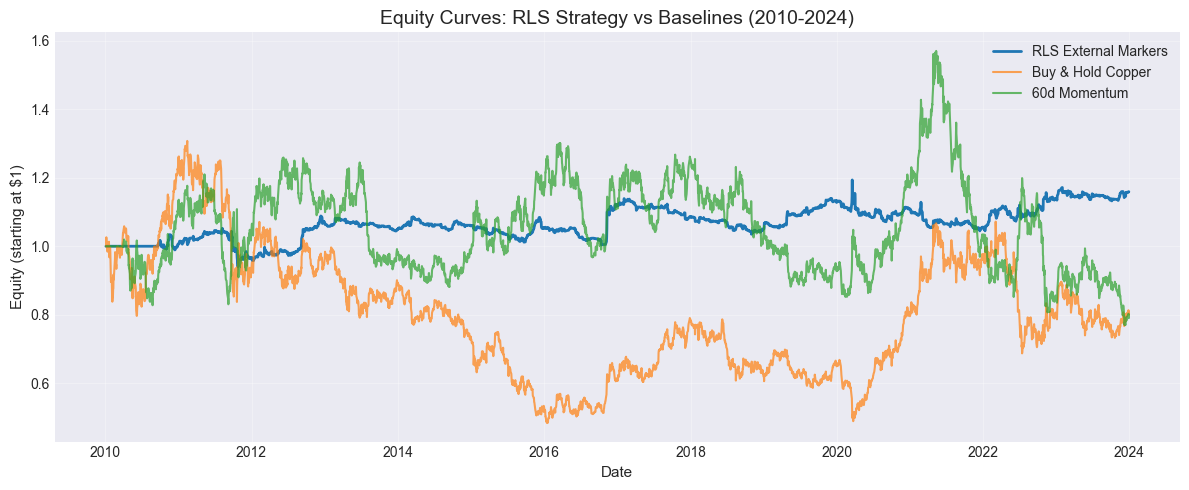

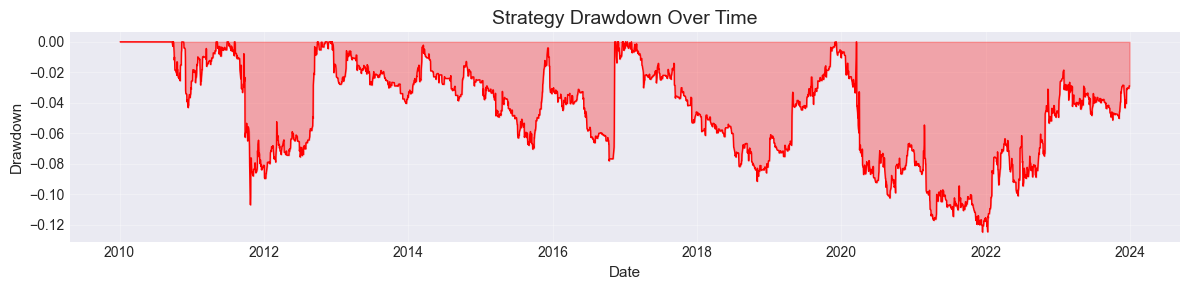

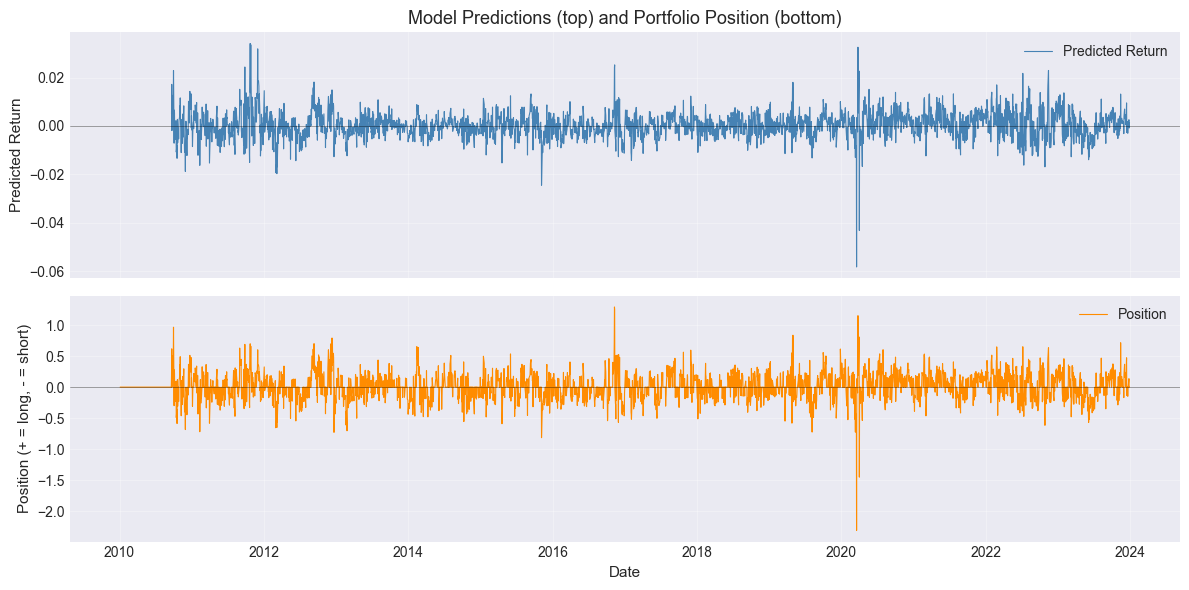

In [82]:
# ---- Chart 1: Equity curves ----
# This is the most important plot. It shows how $1 invested in each
# strategy would have grown (or shrunk) from 2010 to 2024.
plt.figure(figsize=(12, 5))
plt.plot(bt.index, bt["equity"], label="RLS External Markers", linewidth=2)
plt.plot(bh_eq.index, bh_eq, label="Buy & Hold Copper", alpha=0.7)
plt.plot(mom_eq.index, mom_eq, label="60d Momentum", alpha=0.7)
plt.title("Equity Curves: RLS Strategy vs Baselines (2010-2024)", fontsize=14)
plt.ylabel("Equity (starting at $1)", fontsize=11)
plt.xlabel("Date", fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Chart 2: Strategy drawdown over time ----
# Drawdown = current equity / peak equity - 1
# This shows how painful the strategy would have been to actually live through.
# A max drawdown of ~12.5% is quite manageable compared to the 63% drawdown
# you would have experienced just holding copper.
def drawdown(equity: pd.Series) -> pd.Series:
    eq = equity.dropna()
    return eq / eq.cummax() - 1.0

dd = drawdown(bt["equity"])
plt.figure(figsize=(12, 3))
plt.fill_between(dd.index, 0, dd, alpha=0.3, color='red')
plt.plot(dd, color='red', linewidth=1)
plt.title("Strategy Drawdown Over Time", fontsize=14)
plt.ylabel("Drawdown", fontsize=11)
plt.xlabel("Date", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Chart 3: Model predictions and resulting positions ----
# Top panel: what the RLS model predicted for next-day return
# Bottom panel: the position we actually took (after applying risk scaling
# and the signal threshold filter)
# The position chart shows both longs (positive) and shorts (negative)
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(bt["pred"], label="Predicted Return", linewidth=0.8, color='steelblue')
ax[0].axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax[0].set_ylabel("Predicted Return", fontsize=11)
ax[0].set_title("Model Predictions (top) and Portfolio Position (bottom)", fontsize=13)
ax[0].legend(fontsize=10)
ax[0].grid(True, alpha=0.3)

ax[1].plot(bt["w"], label="Position", linewidth=0.8, color='darkorange')
ax[1].axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax[1].set_ylabel("Position (+ = long, - = short)", fontsize=11)
ax[1].set_xlabel("Date", fontsize=11)
ax[1].legend(fontsize=10)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Coefficient Analysis

This section tracks how the RLS coefficients evolve over time. Because RLS adapts continuously, we can see which features the model relied on during different market regimes.

For example, the `price_pct_from_ma60` coefficient (green line) is typically negative, which makes sense for mean reversion: when price is above its 60-day average, the model expects a pullback. During some periods the model leans heavily on this feature, and during others it redistributes weight across different signals. That adaptivity is the whole point of using RLS instead of a static regression.

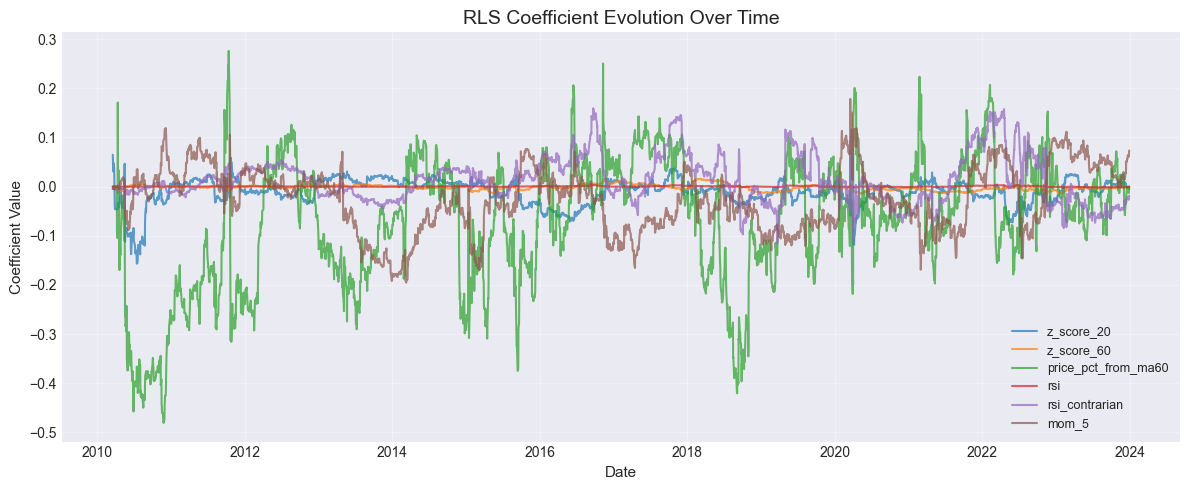

Final RLS coefficients (end of backtest):
  z_score_20               : -0.004673  (short signal)
  z_score_60               : -0.002607  (short signal)
  price_pct_from_ma60      : +0.000669  (long signal)
  rsi                      : -0.000837  (short signal)
  rsi_contrarian           : -0.018108  (short signal)
  mom_5                    : +0.073303  (long signal)
  mom_20                   : +0.007909  (long signal)
  mom_reversal             : -0.000747  (short signal)
  vol_20                   : -2.462465  (short signal)
  vol_60                   : +2.428266  (long signal)
  vol_ratio                : +0.042096  (long signal)
  skew_20                  : -0.000080  (short signal)
  bb_position              : +0.000796  (long signal)
  trend                    : -0.064747  (short signal)
  extreme_move             : +0.006434  (long signal)
  month_sin                : -0.000807  (short signal)
  month_cos                : +0.002039  (long signal)
  dollar_z                 : -0

In [83]:
# This function is similar to walkforward_rls_predictions but also saves
# the coefficient vector at each time step, so we can visualize how the
# model's beliefs change over time.
def walkforward_rls_with_betas(X: pd.DataFrame, y_next: pd.Series, 
                                lam: float = 0.99, burn_in: int = 52):
    Xv = X.values.astype(float)
    yv = y_next.values.astype(float)

    model = RLS(n_features=X.shape[1], lam=lam)
    preds = np.full(len(X), np.nan)
    betas = np.full((len(X), X.shape[1]), np.nan)

    for t in range(len(X)):
        x_t = Xv[t]
        if t >= burn_in:
            preds[t] = model.predict(x_t)
            betas[t] = model.beta.copy()  # snapshot the current coefficients
        if np.isfinite(yv[t]):
            model.update(x_t, yv[t])

    return (pd.Series(preds, index=X.index, name="pred"),
            pd.DataFrame(betas, index=X.index, columns=X.columns))

# Run the coefficient-tracking version (uses a shorter burn-in just to
# see the early adaptation period)
pred_diag, betas = walkforward_rls_with_betas(X, y, lam=0.99, burn_in=52)

# Plot the first 6 features' coefficients over time
# Each line shows how much weight RLS assigns to that feature on any given day
# If a coefficient is consistently negative (like price_pct_from_ma60),
# it means the model treats that feature as a contrarian signal
cols = betas.columns[:min(6, len(betas.columns))]
plt.figure(figsize=(12, 5))
for c in cols:
    plt.plot(betas.index, betas[c], label=c, alpha=0.7)
plt.title("RLS Coefficient Evolution Over Time", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=11)
plt.xlabel("Date", fontsize=11)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the final coefficient values so we can see what the model
# learned by the end of the backtest period
print("Final RLS coefficients (end of backtest):")
final_betas = betas.dropna().iloc[-1]
for feat, val in final_betas.items():
    direction = "long signal" if val > 0 else "short signal" if val < 0 else "neutral"
    print(f"  {feat:25s}: {val:+.6f}  ({direction})")

## Conclusion

This strategy demonstrates that Recursive Least Squares can extract modest but consistent returns from copper futures using a combination of technical and fundamental indicators. The key results:

- **+15.9% total return** over 14 years, in a market where buying and holding lost 20%. This is not a massive return, but it was achieved with much lower risk (5.2% annualized vol vs 22.6% for buy-and-hold).
- **Sharpe ratio of 0.23**, which is positive and meaningful given that both baselines (buy-and-hold and trend-following) produced near-zero or negative risk-adjusted returns over this period.
- **Max drawdown of -12.5%** compared to -63% for buy-and-hold. For most investors, the drawdown profile matters more than the total return -- losing 63% of your capital is a qualitatively different experience than losing 12.5%.

### What worked

The contrarian mean-reversion approach was the right framework for copper in this period. Copper spent most of 2010-2024 range-bound with frequent reversals, which punishes trend-followers but rewards strategies that fade extreme moves. The external indicators (mining stocks, dollar index, FRED macro data) added genuine predictive value by providing context about whether a price move was driven by real fundamentals or likely to reverse.

### Limitations and caveats

- **The returns are modest.** A CAGR of 1.06% would not justify running this as a standalone strategy with significant capital allocation. It is more interesting as a diversifying signal within a broader portfolio.
- **The backtest period is specific.** Copper may behave differently in future decades. If copper enters a sustained bull market (for example, driven by electrification demand), a mean-reversion strategy could underperform.
- **Transaction cost assumptions matter.** We used 1bp per turnover, which is reasonable for institutional futures trading, but retail investors would face higher costs.
- **No slippage or market impact.** The backtest assumes we can trade at the close price, which is approximately but not exactly true.

### Potential improvements

- Incorporating real-time sentiment data (e.g., CFTC positioning reports)
- Testing on out-of-sample data beyond 2024
- Combining with a trend-following overlay that activates during sustained breakouts
- Using cross-validation to tune the forgetting factor and risk aversion parameters